# F4Enix pre-processing pipeline example
This example aim to demonstrate a number of features for the F4Enix tool related to the ``f4enix.input`` sub-module

## Working with MCNP input files

### Quick general overview

In [3]:
# Import the input module
from f4enix.input.MCNPinput import Input

# Load the input file
inp_file = 'ITER_1D'
inp = Input.from_input(inp_file)

In [3]:
# Here are the main attributes of the input
print(inp.cells)
print(inp.surfs)
print(inp.materials)  # datacard class that have their own complete parser
print(inp.transformations)  # uncomplete parser (no transformations in this inp)
print(inp.other_data)  # treated as general data cards, no parser

{'1': <numjuggler.parser.Card object at 0x0000023C1758C160>, '2': <numjuggler.parser.Card object at 0x0000023C1758C190>, '3': <numjuggler.parser.Card object at 0x0000023C1758C130>, '4': <numjuggler.parser.Card object at 0x0000023C1758C0D0>, '5': <numjuggler.parser.Card object at 0x0000023C1758C100>, '6': <numjuggler.parser.Card object at 0x0000023C1758C1F0>, '7': <numjuggler.parser.Card object at 0x0000023C1758C1C0>, '8': <numjuggler.parser.Card object at 0x0000023C1758C220>, '9': <numjuggler.parser.Card object at 0x0000023C1758C250>, '10': <numjuggler.parser.Card object at 0x0000023C1758C280>, '11': <numjuggler.parser.Card object at 0x0000023C1758C2B0>, '12': <numjuggler.parser.Card object at 0x0000023C1758C2E0>, '13': <numjuggler.parser.Card object at 0x0000023C1758C310>, '14': <numjuggler.parser.Card object at 0x0000023C1758C340>, '15': <numjuggler.parser.Card object at 0x0000023C1758C370>, '16': <numjuggler.parser.Card object at 0x0000023C1758C3A0>, '17': <numjuggler.parser.Card ob

In [4]:
# Get a specific card
print(inp.get_cells_by_id([2]))  # cell n.2
print(inp.get_surfs_by_id([1, 2]))  # surfaces n.1 and 2
print(inp.get_cells_by_matID('13'))  # cells to which material 13 is assigned
print(inp.get_materials_subset(['m2', 'm3']))  # materials M2 and M3
print(inp.get_data_cards('SDEF'))  # generic data cards

{'2': <numjuggler.parser.Card object at 0x0000023C1758C190>}
{'1': <numjuggler.parser.Card object at 0x0000023C1758D570>, '2': <numjuggler.parser.Card object at 0x0000023C1758D960>}
{'2': <numjuggler.parser.Card object at 0x0000023C1758F1F0>, '3': <numjuggler.parser.Card object at 0x0000023C1758FAF0>, '4': <numjuggler.parser.Card object at 0x0000023C1758FF70>, '5': <numjuggler.parser.Card object at 0x0000023C1758E9B0>, '6': <numjuggler.parser.Card object at 0x0000023C1758CDF0>, '7': <numjuggler.parser.Card object at 0x0000023C1758F550>, '8': <numjuggler.parser.Card object at 0x0000023C1758F790>, '9': <numjuggler.parser.Card object at 0x0000023C1758F6D0>, '10': <numjuggler.parser.Card object at 0x0000023C1758EE30>, '11': <numjuggler.parser.Card object at 0x0000023C1758EE00>, '12': <numjuggler.parser.Card object at 0x0000023C1758FDF0>, '13': <numjuggler.parser.Card object at 0x0000023C1758ED40>, '14': <numjuggler.parser.Card object at 0x0000023C1758EB90>, '15': <numjuggler.parser.Card ob

### Working with surfaces and cells

A common example may be the need to modify some cells attributes based on an arbitrary logic. Here is an example where the density of cells is reduced by a factor depending on the material. If a constant factor has to be used, consider the ``Input.scale_densities()`` method

In [5]:
from copy import deepcopy
import tempfile  # To have a scratch directory for the example
import os

# It may be useful to preserve the original input
inp2 = deepcopy(inp)

# Set some density correction factors for specific materials
density_factors = {61: 1.1, 63: 10}

# Cycle on the cells dictionary
for idx_cell, cell in inp2.cells.items():
    # Change density based on material
    # mat = cell._get_value_by_type('mat')
    mat = cell.get_m()
    # get the density of the cell
    rho = cell.get_d()
    if mat in [61, 63]:
        cell.set_d(rho*density_factors[mat])
    elif mat == 0:
        pass  # do not change density of void cells
    else:
        # scale all other densitites by a constant factor
        cell.set_d(rho*0.5)

# Print the modified file
outfile = os.path.join(tempfile.gettempdir(), 'new_input.i')
inp.write(outfile)
print(outfile)

C:\Users\laghida\AppData\Local\Temp\new_input.i


This input parser is built on [numjuggler](https://pypi.org/project/numjuggler/), hence every card is a ``numjuggler.parser.Card``. The recommended way to get and modify fields of these cards are to use the ``_get_value_by_type()`` and ``_set_value_by_type()`` methods, as in the example above. Since numjuggler is lacking extensive documentation, to understand which methods are available, the ``dir()`` method can be useful, while the ``values`` attributes should be used to verify the available values to get/modify.

In [6]:
print(type(cell))
print(dir(cell))
cell.values

<class 'numjuggler.parser.Card'>
['_Card__cr', '_Card__d', '_Card__f', '_Card__i', '_Card__m', '_Card__st', '_Card__u', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', '_get_value_by_type', '_protect_nums', '_set_value_by_type', 'apply_map', 'card', 'cstrg', 'ctype', 'debug', 'dtype', 'geom_prefix', 'geom_suffix', 'get_d', 'get_f', 'get_geom', 'get_imp', 'get_input', 'get_m', 'get_refcells', 'get_u', 'get_values', 'hidden', 'input', 'lines', 'name', 'pos', 'print_debug', 'remove_fill', 'remove_spaces', 'set_d', 'template', 'values']


[(106, 'cel'),
 (0, 'mat'),
 ('', '#gpr'),
 (55, 'sur'),
 (54, 'sur'),
 (56, 'sur'),
 ('', '#gsu')]

#### Replace a material

It is possible to replace a material with another one (and another density) or set it to void. This can be done across the entire input or only in specific universes.

In [7]:
# It may be useful to preserve the original input
inp3 = deepcopy(inp)

print('original card:')
print(inp3.cells['2'].card())
# In this case replaces in the entire input
inp3.replace_material(10, '-1', 13)
print('modified card:')
print(inp3.cells['2'].card())

original card:
2     13  7.2058e-002  -55 56   1  -60   imp:n,p=8388608  

modified card:
2     10  -1  -55 56   1  -60   imp:n,p=8388608           



### Working with materials

#### Get info on the material section of the input and switch fraction

In [8]:
# For many operations on materials a libmanager is needed. For most application
# the default libmanager can be used, check the libmanager documentation for
# more details
from f4enix.input.libmanager import LibManager
libmanager = LibManager()

# Get a summary of the materials defined in the input
df_mat, df_submat = inp.materials.get_info(libmanager)
df_mat


Atom Fraction  Mass Fraction
Material Submaterial Element                              
M1       1           H         2.162999e-02      -0.019046
         2           C         1.892004e-02      -0.198524
         3           N         2.059998e-03      -0.025207
         4           O         2.705996e-02      -0.378226
         5           Mg        1.190000e-03      -0.025268
...                                     ...            ...
M74      1           Si        8.157524e-06      -0.000020
                     Ta        6.330820e-07      -0.000010
                     Ti        2.392466e-06      -0.000010
                     Zr        1.255620e-06      -0.000010
                     W         6.220930e-02      -0.999565

[161 rows x 2 columns]

In [9]:
# here the fraction used in the MCNP input (i.e. either mass or atom) is used
df_submat

Fraction  Sub-Material Fraction  \
Material Submaterial Element                                    
M1       1           H        0.021630               1.000000   
         2           C        0.018920               1.000000   
         3           N        0.002060               1.000000   
         4           O        0.027060               1.000000   
         5           Al       0.003930               0.299542   
...                                ...                    ...   
M74      1           Zr       0.000001               0.000020   
M8       1           Be       0.002970               0.034219   
                     Cu       0.082000               0.944769   
                     Ni       0.001824               0.021012   
M9       1           Be       0.123619               1.000000   

                              Material Fraction  
Material Submaterial Element                     
M1       1           H                 0.256858  
         2           C                 0.224677  
         3           N                 0.024463  
         4           O                 0.321339  
         5           Al                0.046669  
...                                         ...  
M74      1           Zr                0.000020  
M8       1           Be                0.034219  
                     Cu                0.944769  
                     Ni                0.021012  
M9       1           Be                1.000000  

[161 rows x 3 columns]

In [10]:
# switch from atom to mass fraction for all materials
inp2 = deepcopy(inp)

# MaterialSection is implemented as a Sequence, hence, it can be iterated
for material in inp2.materials:
    material.switch_fraction('mass', libmanager)

# verify the change, this time get also the different zaid contribution
df_mat, df_submat = inp2.materials.get_info(libmanager, zaids=True)
df_submat

Fraction  Sub-Material Fraction  \
Material Submaterial Element                                    
M1       1           H       -0.019046               1.000000   
         2           C       -0.198524               1.000000   
         3           N       -0.025207               1.000000   
         4           O       -0.378226               1.000000   
         5           Al      -0.092636               0.294839   
...                                ...                    ...   
M74      1           Zr      -0.000010               0.000010   
M8       1           Be      -0.005008               0.005008   
                     Cu      -0.974957               0.974957   
                     Ni      -0.020035               0.020035   
M9       1           Be      -1.000000               1.000000   

                              Material Fraction  
Material Submaterial Element                     
M1       1           H                 0.019046  
         2           C                 0.198524  
         3           N                 0.025207  
         4           O                 0.378226  
         5           Al                0.092636  
...                                         ...  
M74      1           Zr                0.000010  
M8       1           Be                0.005008  
                     Cu                0.974957  
                     Ni                0.020035  
M9       1           Be                1.000000  

[161 rows x 3 columns]

In [11]:
# the zaids are print only in the df_mat when requested
df_mat

Atom Fraction  Mass Fraction
Material Submaterial Element Isotope                                    
M1       1           H       H-1 [1001]          0.256828      -0.019042
                             H-2 [1002]          0.000030      -0.000004
         2           C       C-12 [6012]         0.222273      -0.196224
                             C-13 [6013]         0.002404      -0.002300
         3           N       N-14 [7014]         0.024374      -0.025109
...                                                   ...            ...
M74      1           W       W-180 [74180]       0.001196      -0.001174
                             W-182 [74182]       0.264161      -0.262157
                             W-183 [74183]       0.142647      -0.142344
                             W-184 [74184]       0.305429      -0.306448
                             W-186 [74186]       0.283399      -0.287442

[506 rows x 2 columns]

#### Translation of the material card to different libraries

In [12]:
# --- Change library for all materials ---
inp2.translate('31c', libmanager)
print('All translated to 81c:')
print(inp2.materials['M8'].to_text())

# --- specify a library for every zaid ---
special_zaids = ['4009', '28061']  # to be translated to specific library
non_special = []
for material in inp2.materials:
    for submaterial in material.submaterials:
        for zaid in submaterial.zaidList:
            zaid_str = zaid.element+zaid.isotope
            if zaid_str not in special_zaids:
                non_special.append(zaid_str)

inp2.translate({'80c': special_zaids, '31c': non_special}, libmanager)
print('\nSpecified library for each isotope:')
print(inp2.materials['M8'].to_text())

# --- specify different libraries depending on the original one ---
# this can be useful when D1S libraries only have to be changed for instance
libs = {'31c': '30c', '80c': '31c'}
inp2.translate(libs, libmanager)
print('\nDifferent libraries based on original one:')
print(inp2.materials['M8'].to_text())

All translated to 81c:
c -------------------------------------------------------------------
M8
c   Cu-Be-Ni:  t.a.d. = 8.6794e-002
      28058.31c       -1.337648E-2     $        AB(%)     
      28060.31c       -5.346947E-3     $        AB(%)     
      28061.31c       -2.697346E-4     $        AB(%)     
      28062.31c       -7.802716E-4     $        AB(%)     
      28064.31c       -2.612322E-4     $        AB(%)     
      29063.31c       -6.676429E-1     $        AB(%)     
      29065.31c       -3.073144E-1     $        AB(%)     
       4009.31c       -5.008062E-3     $        AB(%)     
	 plib=84p

Specified library for each isotope:
c -------------------------------------------------------------------
M8
c   Cu-Be-Ni:  t.a.d. = 8.6794e-002
      28058.31c       -1.337648E-2     $        AB(%)     
      28060.31c       -5.346947E-3     $        AB(%)     
      28061.80c       -2.697346E-4     $        AB(%)     
      28062.31c       -7.802716E-4     $        AB(%)     
   

#### Generate new materials from existing ones

In [13]:
# Generate a new material as a composition of existing ones
# The percentages are intended in mass if the fraction is to be expressed in
# mass or in atom otherwise. The new material is created as 'M1'
new_mat = inp2.materials.generate_material(['m2', 'm74'],
                                           [0.2, 0.8],
                                           '31c', libmanager,
                                           fractiontype='mass')
print(new_mat.to_text())

C Material: M2 Percentage: 20.0% (mass)
C Material: M74 Percentage: 80.0% (mass)
M1
c  -----------------------------------------------------------------
C           o-------------------------------------------------------o
c           |    Copper                                             |
c           |    t.a.d. =   8.29204E-02                        M2   |
C           o-------------------------------------------------------o
c
C M2, submaterial 1
      29063.31c       -1.369585E-1     $ Cu-63  AB(%) 68.479
      29065.31c       -6.304150E-2     $ Cu-65  AB(%) 31.521
c
C M74, submaterial 1
      13027.31c       -1.201453E-5     $ Al-27  AB(%) 100.0
       6012.31c       -2.349665E-5     $ C-12   AB(%) 98.842
       6013.31c       -2.753824E-7     $ C-13   AB(%) 1.1584
      20040.31c       -7.742686E-6     $ Ca-40  AB(%) 96.662
      20042.31c       -5.425701E-8     $ Ca-42  AB(%) 0.67736
      20043.31c       -1.159086E-8     $ Ca-43  AB(%) 0.1447
      20044.31c       -1.832560E-7

#### Generate a material from a list of zaids or elements

it is also possible to generate a material from a list of zaids. If the "natural zaids" notation is used, the elements are expanded automatically as shown in the following example.

In [14]:
from f4enix.input.materials import Material
from f4enix.input.libmanager import LibManager

libman = LibManager()  # always needed when libraries are involved
zaids = [(1000, -4.7), (5000, -30.4), (6000, -28.3), (11000, -3.2),
         (16000, -33.1), (14000, -0.06), (26000, -0.08), (7000, -0.4)]
newmat = Material.from_zaids(zaids, libman, '31c', 'header of the material')
print(newmat.to_text())

C header of the material
M1
       1001.31c       -4.698638E+0     $ H-1    AB(%) 99.971
       1002.31c       -1.361756E-3     $ H-2    AB(%) 0.028974
       5010.31c       -5.531343E+0     $ B-10   AB(%) 18.195
       5011.31c       -2.486866E+1     $ B-11   AB(%) 81.805
       6012.31c       -2.797523E+1     $ C-12   AB(%) 98.852
       6013.31c       -3.247744E-1     $ C-13   AB(%) 1.1476
      11023.31c       -3.200000E+0     $ Na-23  AB(%) 100.0
      16032.31c       -3.130391E+1     $ S-32   AB(%) 94.574
      16033.31c       -2.596888E-1     $ S-33   AB(%) 0.78456
      16034.31c       -1.530534E+0     $ S-34   AB(%) 4.624
      16036.31c       -5.866145E-3     $ S-36   AB(%) 0.017722
      14028.31c       -5.513970E-2     $ Si-28  AB(%) 91.899
      14029.31c       -2.892181E-3     $ Si-29  AB(%) 4.8203
      14030.31c       -1.968119E-3     $ Si-30  AB(%) 3.2802
      26054.31c       -4.516447E-3     $ Fe-54  AB(%) 5.6456
      26056.31c       -7.352122E-2     $ Fe-56  AB(%) 

The elements/zaids to be added can be specified with the zaid number but also using their formula as shown below

In [35]:
zaids = [('1001', -100), ('B-0', -200), ('C-12', -50)]
newmat = Material.from_zaids(zaids, libman, '31c', 'header of the material')
print(newmat.to_text())

C header of the material
M1
       1001.31c       -1.000000E+2     $ H-1    AB(%) 100.0
       5010.31c       -3.639041E+1     $ B-10   AB(%) 18.195
       5011.31c       -1.636096E+2     $ B-11   AB(%) 81.805
       6012.31c       -5.000000E+1     $ C-12   AB(%) 100.0


### Miscellanous

Another capability implemented in the MCNP inputs is the possibility to **extract a minimum working MCNP input given a set of cells**. All transformation cards, surfaces, universes and material cards related to these cells will also be extracted. Cell definitions using the # operator are also supported.

In [16]:
cells_to_extract = [34, 35, 36]
outfile = os.path.join(tempfile.gettempdir(), 'extracted.i')
inp.extract_cells(cells_to_extract, outfile)

with open(outfile, 'r') as infile:
    for line in infile:
        print(line.strip('\n'))

ITER 1D
36   7   1.0028e-001  -55 56  12 -13     imp:n,p=32
34   7   1.0028e-001  -55 56  10 -11     imp:n,p=64
35   11  8.5299e-002  -55 56  11 -12     imp:n,p=32

10   cz 447.9 
11   cz 451   
12   cz 455.2 
13   cz 458.2 
*55   pz  1000.0
*56   pz -1000.0

c ------------------------------------------------------------------
C           o-------------------------------------------------------o
c           |    H2O                    
c           |                                                       |
c           |                                                       |
c           |    t.a.d. =   1.0028e-001                        M7   |
C           o-------------------------------------------------------o
c     
M7
       1001.31c        6.684830E-2     $ H-1    AB(%) 99.988
       1002.31c        7.688440E-6     $ H-2    AB(%) 0.0115
c         8016.70c 3.34280E-02  $ O        (nat.)
       8016.31c        3.334680E-2     $ O-16   AB(%) 99.757
       8017.31c        1.270260E-5   

The extract_universe method allows the creation of a new MCNP input with the selected universe. The universe keywords will be erased from the cell definitions. 

In [17]:
inp_universes = Input.from_input("test_universe.i")

outfile = os.path.join(tempfile.gettempdir(), 'extracted_universe.i')
inp_universes.extract_universe(125, outfile)

Or when producing a report, it can be useful to have a summary of the tallies defined in the input

In [18]:
# Normal tallies
inp.get_tally_summary()

,Particle,Description,Normalization,Other multipliers
Tally,,,,
4,N,Neutrons Flux (energy binned) [#/cm^2],1.222e21,<NA>
6,NP,Total Nuclear Heating [W/g],1.9577e8,<NA>
14,P,Photons Flux (energy binned) [#/cm^2],1.222e21,<NA>
16,N,Neutron Heating [W/g],1.9577e8,<NA>
24,N,Fe dpa/FPY,3.8566e8,"[16, 444]"
26,P,Gamma Heating [W/g],1.9577e8,<NA>
34,N,He in 316SS appm/FPY,3.8566e10,"[11, (207:206)]"
44,N,H in 316SS appm/FPY,3.8566e10,"[11, (203:204:205)]"
54,N,T in 316SS appm/FPY,3.8566e10,"[11, 205]"


In [19]:
# FMESHES
inp.get_tally_summary(fmesh=True)

,Particle,Description,Normalization,Other multipliers
Tally,,,,
1004,N,Neutron Flux [#/cc/s],1.222e21,<NA>
1024,P,Photon Flux [#/cc/s],1.222e21,<NA>


In [20]:
inp_universes.get_cells_summary()

,material,density,universe,filler
cell,,,,
1,0,0.0,NaN,125.0
21,4,-1.0,125.0,NaN
22,0,0.0,125.0,NaN
99,0,0.0,NaN,NaN
299,0,0.0,125.0,NaN


## Working with D1S-UNED files

### Reaction file

Reaction files (default name 'reac') contain all the reaction pathways that
should be considered during a D1S-UNED simulation. They are implemented in
F4Enix as a simple list of single reactions.

In [21]:
from f4enix.input.d1suned import Reaction, ReactionFile

# Generate a single reaction (it can also be created from a formatted string)
reac = Reaction('1001.91c', 102, '1002', comment='fake reaction')
reac


parent: 1001.91c
MT channel: 102
daughter: 1002
comment: fake reaction

In [22]:
import tempfile

# A reaction file can be generated from a list of reactions and saved
reac_file = ReactionFile([reac])
outpath = tempfile.gettempdir()
reac_file.write(outpath)

# But more often is instantiated directly from an exisiting file
reac_file = ReactionFile.from_text('reac_fe')
reac_file

       Parent     MT Daughter                                 Comment
    26054.99c    102    26055                                    Fe55
    26054.99c    103    25054                                    Mn54
    26054.99c    107    24051                                    Cr51
    26056.99c    105    25054                                    Mn54
    26056.99c    103    25056                                    Mn56
    26056.99c     16    26055                                    Fe55
    26057.99c     28    25056                                    Mn56
    26057.99c    104    25056                                    Mn56
    26058.99c    102    26059                                    Fe59
    26058.99c    105    25056                                    Mn56

In [23]:
# a convenient method is also provided to change the activation library to use
reac_file.change_lib('98c')
print(reac_file)

# and it is also possible to get a list of parents
print('Parent list:')
reac_file.get_parents()

       Parent     MT Daughter                                 Comment
    26054.98c    102    26055                                    Fe55
    26054.98c    103    25054                                    Mn54
    26054.98c    107    24051                                    Cr51
    26056.98c    105    25054                                    Mn54
    26056.98c    103    25056                                    Mn56
    26056.98c     16    26055                                    Fe55
    26057.98c     28    25056                                    Mn56
    26057.98c    104    25056                                    Mn56
    26058.98c    102    26059                                    Fe59
    26058.98c    105    25056                                    Mn56

Parent list:


['26054', '26056', '26057', '26058']

### Irradiation file

Irradiation files contain information related to the time correction
factors to be used in the D1S-UNED calculation.

In [24]:
from f4enix.input.d1suned import Irradiation, IrradiationFile

# generate a single irradiation from scratch
irr = Irradiation(26059, 1.8e3, ['4e3', '5e3'], comment='Fake irr')
print(irr)


Daughter: 26059
lambda [1/s]: 1800.0
times: ['4e3', '5e3']
comment: Fake irr



In [25]:
import tempfile

# More often an existing irradiation file is parsed
irrad_file = IrradiationFile.from_text('irr_test')

# eliminate the last irradiation and save
irrad_file.irr_schedules = irrad_file.irr_schedules[:-1]
irrad_file.write(tempfile.gettempdir())

# get the list of irradiation schedules
irrad_file.irr_schedules

[['24051', '2.896e-07', '5.982e+00', '5.697e+00', 'Cr51'],
 ['25054', '2.570e-08', '5.881e+00', '1.829e+00', 'Mn54'],
 ['26055', '8.031e-09', '4.487e+00', '6.364e-01', 'Fe55']]

In [26]:
# auxiliary method to retrieve a specific irradiation
print(irrad_file.get_irrad('24051'))

# auxiliary method to get all daughters
print(irrad_file.get_daughters())


Daughter: 24051
lambda [1/s]: 2.896e-07
times: ['5.982e+00', '5.697e+00']
comment: Cr51

['24051', '25054', '26055']


### D1S MCNP input

The D1S-UNED MCNP input is exactly the same as a normal MCNP input with a few
additional cards. In F4Enix is implemented as a child of the ``Input`` class
and it includes as attributes also an ``IrradiationFile`` and ``ReactionFile``
objects. There are many ways to initialize this object and the simplest one
is when all text input files are aleady available and can be parsed.

In [27]:
from f4enix.input.d1suned import ReactionFile, IrradiationFile
from f4enix.input.MCNPinput import D1S_Input

# Simplest case, all text input are already present and can be parsed
d1s_inp = D1S_Input.from_input('d1stest.i', irrad_file='irr_test',
                               reac_file='reac_fe')
print(type(d1s_inp.reac_file))
print(type(d1s_inp.irrad_file))

<class 'f4enix.input.d1suned.ReactionFile'>
<class 'f4enix.input.d1suned.IrradiationFile'>


Nevertheless, F4Enix can also help in the automatic generation of irrad and
react file. An example can be the following: let's suppose that a number
of daughters have been identified as the most important radioactive isotopes
of interest for a specific SDDR computation. A reaction file can be built
automatically that will include all the reactions available in a specific
activation library that lead to one of the listed daughters. Only parents
that are included in the materials of the MCNP input will be considered.

In [28]:
from f4enix.input.libmanager import LibManager

# Parse only the MCNP input and the irrad file containing the list of daughters
# to be considered
d1s_inp = D1S_Input.from_input('d1stest.i', irrad_file='irr_test')
print('Daughters:')
print(d1s_inp.irrad_file.get_daughters())

# generate the reaction file with the default Library Manager and the 99c lib.
lm = LibManager()
d1s_inp.get_reaction_file(lm, '99c')
d1s_inp.reac_file

Daughters:
['24051', '25054', '26055', '26059']


       Parent     MT Daughter                                 Comment
    24050.99c    102    24051                          Cr-50 -> Cr-51
    24052.99c     16    24051                          Cr-52 -> Cr-51
    25055.99c     16    25054                          Mn-55 -> Mn-54
    26054.99c    102    26055                          Fe-54 -> Fe-55
    26054.99c    103    25054                          Fe-54 -> Mn-54
    26054.99c    107    24051                          Fe-54 -> Cr-51
    26056.99c    105    25054                          Fe-56 -> Mn-54
    26056.99c     16    26055                          Fe-56 -> Fe-55
    26058.99c    102    26059                          Fe-58 -> Fe-59
    27059.99c    103    26059                          Co-59 -> Fe-59
    28058.99c    112    25054                          Ni-58 -> Mn-54
    28062.99c    107    26059                          Ni-62 -> Fe-59

If no decision has been taken on which daughters should be considered,
F4Enix also allows to have a list of all the possible reactions that
are foreseen from a specified activation library where the parent isotope
is listed an at least one material of the MCNP input.


In [29]:
# parse only the MNCP input
d1s_inp = D1S_Input.from_input('d1stest.i')
lm = LibManager()
# this is a list of reactions and can be directly used to initialize a reaction
# file if needed.
d1s_inp.get_potential_paths(lm, '98c')[:3]

[
 parent: 13027.98c
 MT channel: 107
 daughter: 11024
 comment: Al-27 -> Na-24,
 
 parent: 24050.98c
 MT channel: 102
 daughter: 24051
 comment: Cr-50 -> Cr-51,
 
 parent: 24052.98c
 MT channel: 16
 daughter: 24051
 comment: Cr-52 -> Cr-51]

Another common task could be to translate a d1s input (and reaction file)
from a library to another. The first method to do this is a 1 to 1 conversion.
This is also available also in a standard MCNP input. This works if the decay
pathways of interest (reactions) are available in both libraries. This check
is not performed by F4Enix!

In [30]:
d1s_inp = D1S_Input.from_input('d1stest.i', irrad_file='irr_test',
                               reac_file='reac_fe')

print('before:')
print(d1s_inp.materials['M1'].to_text()[-500:])

# this translates all activated zaid with old library 99c to the new 98c. Also
# the transport library is changed here, from 21c to 31c
new_lib = {'99c': '98c', '21c': '31c'}
lm = LibManager()
d1s_inp.translate(new_lib, lm)

# Check the translation (only a piece of a material)
print('\nafter:')
print(d1s_inp.materials['M1'].to_text()[-500:])

# Manually change also the library in the reaction file
d1s_inp.reac_file.change_lib('98c')
print('\nreac file:')
d1s_inp.reac_file

before:
0E-5     $        AB(%)     
      74182.99c        6.254000E-7     $        AB(%)     
      74183.21c        3.377160E-7     $        AB(%)     
      74184.21c        7.231040E-7     $        AB(%)     
      74186.99c        6.709480E-7     $        AB(%)     
      82206.21c        4.048800E-7     $        AB(%)     
      82207.21c        3.712800E-7     $        AB(%)     
      82208.21c        8.803200E-7     $        AB(%)     
      83209.21c        1.660000E-6     $        AB(%)     

after:
0E-5     $        AB(%)     
      74182.98c        6.254000E-7     $        AB(%)     
      74183.31c        3.377160E-7     $        AB(%)     
      74184.31c        7.231040E-7     $        AB(%)     
      74186.98c        6.709480E-7     $        AB(%)     
      82206.31c        4.048800E-7     $        AB(%)     
      82207.31c        3.712800E-7     $        AB(%)     
      82208.31c        8.803200E-7     $        AB(%)     
      83209.31c        1.660000E-6     $ 

       Parent     MT Daughter                                 Comment
    26054.98c    102    26055                                    Fe55
    26054.98c    103    25054                                    Mn54
    26054.98c    107    24051                                    Cr51
    26056.98c    105    25054                                    Mn54
    26056.98c    103    25056                                    Mn56
    26056.98c     16    26055                                    Fe55
    26057.98c     28    25056                                    Mn56
    26057.98c    104    25056                                    Mn56
    26058.98c    102    26059                                    Fe59
    26058.98c    105    25056                                    Mn56

In addition to this, a new translating method has been defined for the
``D1S_Input`` object. Let's suppose that this is the first time a D1S-INPUT
is generated for a specific application. Once irradiation and reaction files
have been defined, the MCNP input can be translated specifying an activation
and a transport lib. The activation lib will be automatically assigned to
all parents indicated the reac file.

In [31]:
# reset everything to just one lib
d1s_inp.translate('31c', lm)
print('before:')
print(d1s_inp.materials['M1'].to_text()[2000:2500])

# smart translate
d1s_inp.smart_translate('99c', '00c', lm)
print('\nafter:')
print(d1s_inp.materials['M1'].to_text()[2000:2500])

before:
-1     $        AB(%)     
      26057.31c        1.065860E-2     $        AB(%)     
      26058.31c        1.418460E-3     $        AB(%)     
      27059.31c        3.680000E-4     $        AB(%)     
      28058.31c        6.167770E-2     $        AB(%)     
      28060.31c        2.375810E-2     $        AB(%)     
      28061.31c        1.032750E-3     $        AB(%)     
      28062.31c        3.292860E-3     $        AB(%)     
      28064.31c        8.385940E-4     $        AB(%)     
 

after:
-1     $        AB(%)     
      26057.99c        1.065860E-2     $        AB(%)     
      26058.99c        1.418460E-3     $        AB(%)     
      27059.00c        3.680000E-4     $        AB(%)     
      28058.00c        6.167770E-2     $        AB(%)     
      28060.00c        2.375810E-2     $        AB(%)     
      28061.00c        1.032750E-3     $        AB(%)     
      28062.00c        3.292860E-3     $        AB(%)     
      28064.00c        8.385940E-4     $   

To conclude, two other cards that are needed for a D1S-UNED run can be
automatically generated using F4Enix. The PIKMT card and the FU card to
track the contribution of either parents or daughters to a specific
tally.

In [32]:
d1s_inp = D1S_Input.from_input('d1stest.i', irrad_file='irr_test',
                               reac_file='reac_fe')

# add a PIKMT card to the input based on reac file
d1s_inp.add_PIKMT_card()
print(d1s_inp.other_data['PIKMT'].card())

# Add a FU card to a tally
d1s_inp.add_track_contribution('F124', [26054], who='parent')
print(d1s_inp.other_data['F124'].card())

PIKMT
         26054    0
         26056    0
         26057    0
         26058    0

c
C ---------------- Dose Calculation --------------------------------------------
C    tally  *    ICF           *      DF        *   Sv/pSv       *     s/h    
C [p/cm^2/#]* 1.0714e17 [#/s]) * [pSv/(p/cm^2)] * 1e-12 [Sv/pSv] * 3600 [s/h] 
C ------------------------------------------------------------------------------
F124:p 10 11 12 13
FU124 0
         -26054



## Working with weight window files and GVRs

The ww_gvr module can operate on Weight Window files to, for example, reduce the likelihood of long history problems, or to add or remove a secondary particle.
It can also generate Global Variance Reduction files (GVR) by reading a Meshtally file.
This module can be used via Python scripting or through a command line interface.

### Example of use via Python scripting

In [14]:
from f4enix.input.ww_gvr import WW
from f4enix.input.ww_gvr.utils import WW_SIMPLE_CART

# Load the weight window by reading a WW file
ww = WW.load_from_ww_file(WW_SIMPLE_CART)  # WW_SIMPLE_CART is a path to a WW file like "D:/DATA/WW/ww_simple_cart.ww"

print(ww)

 ww_simple_cart weight window
       ----From---- -----To----- --No. Bins--
 I -->    -15.0         15.0          2      
 J -->    -15.0         16.0          3      
 K -->    -15.0         20.0          1      

 Cartesian coordinates, 6 voxels.

 The weight window contains 1 particle/s

 ---------------------Neutron----------------------
 Energy bins:         [100.0]
 Min value:           8.98E-02
 Max value:           6.73E-01
 No.Bins > 0 [%]:     100.0%
 Average ratio:       5.97E+00
 Max ratio:           6.74E+00


In [15]:
# Normalize the weight window
ww.multiply(1.2)

# Soft the weight window
ww.soften(0.5)

# Add a secondary particle
ww.add_particle(norm=0.2, soft=1.)

# Ensure that there are no high ratios between voxels to avoid long histories
ww.mitigate_long_histories(max_ratio=10.)

# Save the modified ww to a new file
ww.write_to_ww_file('D:/ww_modified.ww')

# Export the ww as a VTK to visualize it in Paraview
ww.export_as_vtk('D:/ww_modified.vtk')

print(ww)

 ww_simple_cart weight window
       ----From---- -----To----- --No. Bins--
 I -->    -15.0         15.0          2      
 J -->    -15.0         16.0          3      
 K -->    -15.0         20.0          1      

 Cartesian coordinates, 6 voxels.

 The weight window contains 2 particle/s

 ---------------------Neutron----------------------
 Energy bins:         [100.0]
 Min value:           3.28E-01
 Max value:           8.99E-01
 No.Bins > 0 [%]:     100.0%
 Average ratio:       2.44E+00
 Max ratio:           2.60E+00

 ----------------------Photon----------------------
 Energy bins:         [100.0]
 Min value:           6.57E-02
 Max value:           1.80E-01
 No.Bins > 0 [%]:     100.0%
 Average ratio:       2.44E+00
 Max ratio:           2.60E+00


c:\ProgramData\Anaconda3\envs\py311\Lib\site-packages\pyvista\jupyter\notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


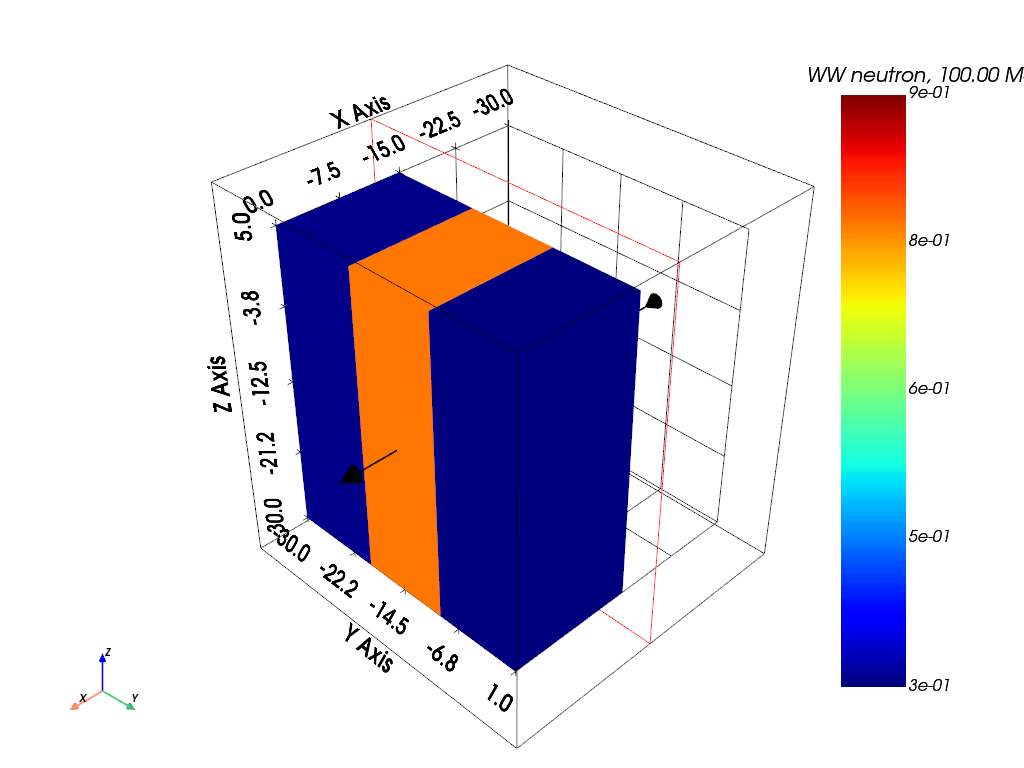

In [12]:
# Interactive plot
ww.plot()

### Creation of a GVR

In [16]:
from f4enix.input.ww_gvr.utils import MESHTALLY_CART

gvr = WW.create_gvr_from_meshtally_file(MESHTALLY_CART)  # MESHTALLY_CART is a path to a meshtally file like "D:/DATA/WW/meshtally_cart.msh"

print(gvr)

 meshtally_cart weight window
       ----From---- -----To----- --No. Bins--
 I -->    -10.0         20.0          3      
 J -->     20.0         40.0          4      
 K -->     15.0         25.0          2      

 Cartesian coordinates, 24 voxels.

 The weight window contains 1 particle/s

 ---------------------Neutron----------------------
 Energy bins:         [100.0]
 Min value:           1.30E-01
 Max value:           3.33E-01
 No.Bins > 0 [%]:     100.0%
 Average ratio:       1.25E+00
 Max ratio:           1.31E+00


### Use via a Command Line Interface
The CLI can be invoked by `python -m f4enix.input.ww_gvr` 
